# DQMC


## Hamiltonian & Partition function


Use square-lattice Hubbard model as an example here. For detailed analytical derivation, please check https://quantummc.xyz/2020/10/11/dqmc-note/ .


The half-filling Hamiltonian is: $$H=-t\mathop{\sum}\limits_{<i,j>\sigma}c_{i\sigma}^\dagger c_{j\sigma}+h.c.+U\mathop{\sum}\limits_i (n_{i\uparrow}-\frac{1}{2})(n_{i\downarrow}-\frac{1}{2}).$$

After Trotter decomposition, the partition is $$Tr\{e^{-\beta H}\}=Tr\{(e^{-\Delta\tau H})^{L_\tau}\}$$

For the kinetic energy, the sum for spin-up and spin-down are the same and for example it can be expressed as :
$$H_0=c^\dagger_\uparrow T c_\uparrow=-t\mathop{\sum}\limits_{<i,j>}c_{i\uparrow}^\dagger c_{j\uparrow}+h.c. $$ 

For the interaction,  it can be expressed as :
$$H_U=U\mathop{\sum}\limits_i (n_{i\uparrow}-\frac{1}{2})(n_{i\downarrow}-\frac{1}{2})=-\frac{U}{2}(n_\uparrow-n_\downarrow)^2+\frac{U}{4}$$For details, check https://journals.aps.org/prb/abstract/10.1103/PhysRevB.7.432 .
After HS transformation: $$e^{-\Delta\tau H_U}=\gamma\sum_{s=\pm 1}e^{\alpha s(n_\uparrow-n_\downarrow)},$$ with $\gamma=\frac{1}{2}e^{-\Delta\tau U/4}$, and $\cosh(\alpha)=e^{\Delta\tau U/2}$.

Therefore, the expanded partition function is:
$$Z=\sum_{s_{i, l}=\pm 1}\gamma^{NL_\tau}Tr_F\{ \prod_{l=1}^{L_\tau}[(\prod_ie^{\alpha s_{i,l}n_{i\uparrow}})(e^{-\Delta\tau c_\uparrow^\dagger T c_\uparrow})(\prod_ie^{-\alpha s_{i,l}n_{i\downarrow}})(e^{-\Delta\tau c_\downarrow^\dagger T c_\downarrow}) ]\}\\ =\gamma^{NL_\tau}\sum_{s_{i,j}}\prod_{\sigma=\uparrow\downarrow}Det[I+B^\sigma(L_\tau\Delta\tau,(L_\tau-1)\Delta\tau)\dots B^\sigma(\Delta\tau,0)]$$
where $B^{\sigma=\uparrow,\downarrow}(l_2\Delta\tau,l_1\Delta\tau)=\prod_{l=l_1+1}^{l_2}e^{\alpha Diag(\vec S_l)}e^{-\Delta\tau T}$ and Diag($\vec S_l$) is a diagonal matrix with the diagonal elements being $s_{i,l}$.



## Code

In [24]:
import numpy as np
import scipy.linalg
import copy
import random
import math
import matplotlib.pyplot as plt

### System parameters

In [25]:
Lx=4
Ly=4
L=Lx*Ly   # which is the number of lattice sites N
t=1       # hopping amplitude
beta=4
dt=0.1
total_slices=int(beta/dt)


N_wrap_interval=5; #deciding when to do stabilization
I=np.identity(L)
total_sweeps=2000;    #total MC steps
N_warmup_sweep=1000;  # thermalization only, not measure; 
# in fact we do not need so many steps for thermalization in this system

U_list=[0.5,1,1.5,2,2.5,3,3.5,4,4.5]
Ek_list=np.zeros((len(U_list),2))
D_list=np.zeros((len(U_list),2))
S_list=np.zeros((len(U_list),2))


Here, I will show the code for simulating square-lattice Hubbard model and measure kinetic energy $E_k$, double occupancy $D$, and structure factor $S(\pi,\pi)$ with changing $U$.

When measuring $$S(\pi,\pi)=\frac{1}{N}\sum_{ij}e^{-i\textbf{Q}=(\pi,\pi))(\textbf{r}_i-\textbf{r}_j)}\langle s_i^zs_j^z\rangle =\frac{1}{N}\sum_{ij}(-)^{i-j}(\langle n_{i\uparrow}n_{j\uparrow} \rangle+\langle n_{i\downarrow}n_{j\downarrow} \rangle-\langle n_{i\uparrow}n_{j\downarrow} \rangle-\langle n_{i\downarrow}n_{j\uparrow} \rangle), $$
$(-)^{i-j}$ is $+1$ if i and j are on the same sublattice, but $-1$ if not. This is general for lattice models, so I just write in this form for square lattice as well.

In [26]:
# sublattice

sub_A=np.zeros(int(L/2))
sub_B=np.zeros(int(L/2))
sub_indexa=0
sub_indexb=0
for subix in range(Lx):
    for subiy in range(Ly):
        if np.mod(subix+subiy+1,2)==0:
            sub_A[sub_indexa]=subix+subiy*Ly
            sub_indexa=sub_indexa+1
        else:
            sub_B[sub_indexb]=subix+subiy*Ly
            sub_indexb=sub_indexb+1

In [27]:
sub_A

array([ 4., 12.,  1.,  9.,  6., 14.,  3., 11.])

In [28]:
sub_B

array([ 0.,  8.,  5., 13.,  2., 10.,  7., 15.])

### T matrix

In [29]:
matrix_T=np.zeros((L,L))   #define T matrix
for i1 in range(Lx):
    for i2 in range(Ly):
        it=i1+Lx*i2
        it1=it+1        #right neighbor
        if i1+1>Lx-1:
            it1=it1-Lx
            
        it2=it-1       #left
        if i1-1<0:
            it2=it2+Lx
        
        it3=it+Ly      #down
        if it3>L-1:
            it3=it3-L
        
        it4=it-Ly      #up
        if it4<0:
            it4=it4+L
       
        matrix_T[it,it1]=-t
        matrix_T[it,it2]=-t
        matrix_T[it,it3]=-t
        matrix_T[it,it4]=-t


In [30]:
matrix_eT=scipy.linalg.expm(-dt*matrix_T);

### $e^{H_U}$ matrix

In [31]:
def eV_up(lattice_temp,L_temp,alpha_temp):  #spin-up
    mat_v=np.zeros((L_temp,L_temp))
    for ivu in range(L_temp):
        mat_v[ivu,ivu]=lattice_temp[ivu]
    return scipy.linalg.expm(alpha_temp*mat_v)

def eV_down(lattice_temp,L_temp,alpha_temp):  #spin-down
    mat_v=np.zeros((L_temp,L_temp))
    for ivd in range(L_temp):
        mat_v[ivd,ivd]=lattice_temp[ivd]
    return scipy.linalg.expm(-alpha_temp*mat_v)



### UDV decomposition

Define udv decomposition function here with pivoting QR decomposition.
For my notation: $$G(\tau,\tau)=[1+B(\tau,0)B(\beta,\tau)]^{-1}=[1+U_LD_LV_LU_RD_RV_R]^{-1}$$
After QR decomposition with pivoting, we have $QR=A[:,p]$, I take $Q$ as $U$ and the diagonal elements of $R$ (the diagonal elements are the eigenvalues of it) as $D$, and $D^{-1}R$ as $V$ after changing the order of the columns.

In [32]:
def pivoted_qr(mat_tod,L_temp):
    [qhere,rhere,phere]=scipy.linalg.qr(mat_tod,pivoting=True)
    #print(qhere,rhere,phere)
    prhere=np.zeros_like(phere)
    for iqr in range(L_temp):
        key_here=iqr
        val_here=phere[iqr]
        prhere[val_here]=key_here
    uhere=qhere
    dhere=abs(np.real(np.diag(rhere)))
    rhere=np.dot(np.diag(1./(dhere)),rhere)
    rnew=np.zeros((L_temp,L_temp))
    for irnew in range(L_temp):
        rnew[:,irnew]=rhere[:,prhere[irnew]]
    dhere=np.diag(dhere)
    vhere=np.transpose(rnew)
    return uhere,dhere,vhere
# be careful in this definition: A=u*d*transpose(v)

### Initial settings

Set initial configurations, and B matrices


In [33]:
def set_configuration(slice_temp,L_temp):                   
    lattice_temp=np.zeros((slice_temp,L_temp))
    for ilat in range(slice_temp):
        for jlat in range(L_temp):
            lattice_temp[ilat,jlat]=np.random.randint(2)*2-1
    return lattice_temp

def set_Blists(slice_temp,lattice_temp,alpha):
    Bup=np.zeros(((slice_temp,L,L)))
    Bdown=np.zeros(((slice_temp,L,L)))
    for ibini in range(slice_temp):
        Bup[ibini]=np.dot(eV_up(lattice_temp[ibini],L,alpha),matrix_eT)
        Bdown[ibini]=np.dot(eV_down(lattice_temp[ibini],L,alpha),matrix_eT)
    return Bup,Bdown
            

### Markov chain simulation

When sweeping each tiem slice, we determine whether to do stablization, if so, we do the udv decompositions to recalculate the Green's function, if not: $G(\tau+\Delta\tau,\tau+\Delta\tau)=B(\tau+\Delta\tau,\tau)G(\tau,\tau)B^{-1}(\tau+\Delta\tau,\tau)$. 

When doing the flipping of lattice sites, the ratio is $r=1+\Delta_{ii}(1-G_{ii})$ with ${\Delta}=e^{V(\vec S_l')}e^{-V(\vec S_l)}-\textbf{I}$. If the local update is accepted, $G'(\tau,\tau)=G-G(:,i)\Delta_{ii}\frac{1}{r}(\textbf{I}-G)(i,:)$, where $i$ is the lattice index.

In [34]:
def Markov_simulation(U):
    alpha=math.acosh(np.exp(dt*U/2)) 
    Ek=np.zeros(total_sweeps-N_warmup_sweep)
    double_occupancy=np.zeros(total_sweeps-N_warmup_sweep)
    structure_factor=np.zeros(total_sweeps-N_warmup_sweep)
    N_measurement=0
    #initial lattice
    lattice_list=set_configuration(total_slices,L)
    B_up_list,B_down_list=set_Blists(total_slices,lattice_list,alpha)
    #initial Green's function
    buUL=np.eye(L);buSL=np.eye(L);buVL=np.eye(L);bdUL=np.eye(L);bdSL=np.eye(L);bdVL=np.eye(L) 
    buUR=np.eye(L);buSR=np.eye(L);buVR=np.eye(L);bdUR=np.eye(L);bdSR=np.eye(L);bdVR=np.eye(L)
    # these above are the udv matrices, we use L to represent those from B(tau,0) and R means those from B(beta,tau)
    # UDV are USV here, 'u' means up and 'd' means spin-down
    for igini in range(total_slices):
        if igini==0:
            buUL,buSL,buVL=pivoted_qr(B_up_list[igini],L)
            bdUL,bdSL,bdVL=pivoted_qr(B_down_list[igini],L)
        else:
            buUL,buSL,bauVL=pivoted_qr(np.dot(np.dot(B_up_list[igini],buUL),buSL),L)
            buVL=np.dot(buVL,bauVL)
            bdUL,bdSL,badVL=pivoted_qr(np.dot(np.dot(B_down_list[igini],bdUL),bdSL),L)
            bdVL=np.dot(bdVL,badVL)
    #below  's' means min and 'b' means max
    buSLs=copy.deepcopy(buSL);buSLb=copy.deepcopy(buSL);buSRs=copy.deepcopy(buSR);buSRb=copy.deepcopy(buSR)
    bdSLs=copy.deepcopy(bdSL);bdSLb=copy.deepcopy(bdSL);bdSRs=copy.deepcopy(bdSR);bdSRb=copy.deepcopy(bdSR)
    for mhere in range (len(buSL)):
        if buSL[mhere,mhere]>1:
            buSLs[mhere,mhere]=1
        else:
            buSLb[mhere,mhere]=1
        if bdSL[mhere,mhere]>1:
            bdSLs[mhere,mhere]=1
        else:
            bdSLb[mhere,mhere]=1
    G_up=np.dot(np.dot(np.dot(np.dot(np.linalg.inv(np.transpose(buVR)),(np.diag(1./np.diag(buSRb)))),\
                              np.linalg.inv(np.dot(np.dot(np.diag(1./np.diag(buSLb)),np.linalg.inv(np.dot(np.transpose(buVR),buUL))),\
                                                   np.diag(1./np.diag(buSRb)))+np.dot(np.dot(np.dot(buSLs,np.transpose(buVL)),buUR),\
                                                                                      buSRs))),(np.diag(1./np.diag(buSLb)))),np.linalg.inv(buUL))
    G_down=np.dot(np.dot(np.dot(np.dot(np.linalg.inv(np.transpose(bdVR)),(np.diag(1./np.diag(bdSRb)))),\
                              np.linalg.inv(np.dot(np.dot(np.diag(1./np.diag(bdSLb)),np.linalg.inv(np.dot(np.transpose(bdVR),bdUL))),\
                                                   np.diag(1./np.diag(bdSRb)))+np.dot(np.dot(np.dot(bdSLs,np.transpose(bdVL)),bdUR),\
                                                                                      bdSRs))),(np.diag(1./np.diag(bdSLb)))),np.linalg.inv(bdUL))
    
    # start sweeping, here I just write down sweeping from slice 0 to beta, you can add from beta to 0 by yourself
    for N_sweep in range(total_sweeps):
        if np.mod (N_sweep,100)==0:
            print('U=',U,'start sweep', N_sweep)
        slice_tomeasure=np.random.randint(total_slices)
        for time_slice in range (total_slices):
            if np.mod(time_slice+1,N_wrap_interval)==0:   #whether to do stabilization
                
                # just define the decomposed matrices, you can choose not to define here since these variables already exist
                buUL=np.eye(L);buSL=np.eye(L);buVL=np.eye(L);bdUL=np.eye(L);bdSL=np.eye(L);bdVL=np.eye(L) 
                buUR=np.eye(L);buSR=np.eye(L);buVR=np.eye(L);bdUR=np.eye(L);bdSR=np.eye(L);bdVR=np.eye(L)
                for irecalc in range (time_slice+1):
                    if irecalc==0:
                        buUL,buSL,buVL=pivoted_qr(B_up_list[irecalc],L)
                        bdUL,bdSL,bdVL=pivoted_qr(B_down_list[irecalc],L)
                    else:
                        buUL,buSL,bauVL=pivoted_qr(np.dot(np.dot(B_up_list[irecalc],buUL),buSL),L)
                        buVL=np.dot(buVL,bauVL)
                        bdUL,bdSL,badVL=pivoted_qr(np.dot(np.dot(B_down_list[irecalc],bdUL),bdSL),L)
                        bdVL=np.dot(bdVL,badVL)
                for jrecalc in reversed(range(time_slice+1,total_slices)):
                    if jrecalc==total_slices-1:
                        buUR,buSR,buVR=pivoted_qr(B_up_list[jrecalc],L)
                        bdUR,bdSR,bdVR=pivoted_qr(B_down_list[jrecalc],L)
                    else:
                        bauUR,buSR,buVR=pivoted_qr(np.dot(np.dot(buSR,np.transpose(buVR)),B_up_list[jrecalc]),L)
                        buUR=np.dot(buUR,bauUR)
                        badUR,bdSR,bdVR=pivoted_qr(np.dot(np.dot(bdSR,np.transpose(bdVR)),B_down_list[jrecalc]),L)
                        bdUR=np.dot(bdUR,badUR)
                buSLs=copy.deepcopy(buSL);buSLb=copy.deepcopy(buSL);buSRs=copy.deepcopy(buSR);buSRb=copy.deepcopy(buSR)
                bdSLs=copy.deepcopy(bdSL);bdSLb=copy.deepcopy(bdSL);bdSRs=copy.deepcopy(bdSR);bdSRb=copy.deepcopy(bdSR)
                for mhere in range (len(buSL)):
                    if buSL[mhere,mhere]>1:
                        buSLs[mhere,mhere]=1
                    else:
                        buSLb[mhere,mhere]=1
                    if bdSL[mhere,mhere]>1:
                        bdSLs[mhere,mhere]=1
                    else:
                        bdSLb[mhere,mhere]=1
                    if buSR[mhere,mhere]>1:
                        buSRs[mhere,mhere]=1
                    else:
                        buSRb[mhere,mhere]=1
                    if bdSR[mhere,mhere]>1:
                        bdSRs[mhere,mhere]=1
                    else:
                        bdSRb[mhere,mhere]=1
                G_up=np.dot(np.dot(np.dot(np.dot(np.linalg.inv(np.transpose(buVR)),(np.diag(1./np.diag(buSRb)))),\
                                          np.linalg.inv(np.dot(np.dot(np.diag(1./np.diag(buSLb)),\
                                                                      np.linalg.inv(np.dot(np.transpose(buVR),buUL))),\
                                                               np.diag(1./np.diag(buSRb)))+np.dot(np.dot(np.dot(buSLs,np.transpose(buVL)),\
                                                                                                         buUR),buSRs))),(np.diag(1./np.diag(buSLb)))),np.linalg.inv(buUL))
                #print(G_up)
                G_down=np.dot(np.dot(np.dot(np.dot(np.linalg.inv(np.transpose(bdVR)),(np.diag(1./np.diag(bdSRb)))),\
                                            np.linalg.inv(np.dot(np.dot(np.diag(1./np.diag(bdSLb)),\
                                                                        np.linalg.inv(np.dot(np.transpose(bdVR),bdUL))),\
                                                                 np.diag(1./np.diag(bdSRb)))+np.dot(np.dot(np.dot(bdSLs,np.transpose(bdVL)),bdUR),\
                                                                                                    bdSRs))),(np.diag(1./np.diag(bdSLb)))),np.linalg.inv(bdUL))
            else:
                G_up=np.dot(np.dot(B_up_list[time_slice],G_up),np.linalg.inv(B_up_list[time_slice]))
                #print(G_up,'trans')
                
                G_down=np.dot(np.dot(B_down_list[time_slice],G_down),np.linalg.inv(B_down_list[time_slice]))
            
            #start updating
            for N_site in range(L):
                array_one=np.zeros(L)                        # one row of identity matrix to be defined
                si=lattice_list[time_slice,N_site]          # spin
                sip=-lattice_list[time_slice,N_site]        #flip
                delta_up=np.exp(alpha*sip)*np.exp(-alpha*si)-1
                delta_down=np.exp(-alpha*sip)*np.exp(alpha*si)-1
                R_up=(1+delta_up*(1-G_up[N_site,N_site]))
                R_down=(1+delta_down*(1-G_down[N_site,N_site]))
                ratio_here=R_up*R_down
                if random.random()<ratio_here:
                    array_one[N_site]=1
                    G_up=G_up-np.dot((G_up[:,N_site]*delta_up).reshape(L,1),(array_one-G_up[N_site,:]).reshape(1,L))/R_up
                    #print(G_up,'update')
                    G_down=G_down-np.dot((G_down[:,N_site]*delta_down).reshape(L,1),(array_one-G_down[N_site,:]).reshape(1,L))/R_down
                    lattice_list[time_slice,N_site]=sip
            B_up_list[time_slice]=np.dot(eV_up(lattice_list[time_slice],L,alpha),matrix_eT)
            B_down_list[time_slice]=np.dot(eV_down(lattice_list[time_slice],L,alpha),matrix_eT)
            
            #start measurement
            if time_slice==slice_tomeasure and N_sweep+1>=N_warmup_sweep:
                ekhere=0; euhere=0; sfhere=0
                Meup=I-G_up; Medn=I-G_down
                for ik in range(L):
                    for ikj in range(L):
                        if ik==ikj:
                            euhere=euhere+Meup[ik,ik]*Medn[ik,ik]

                        ekhere=ekhere+Meup[ik,ikj]*matrix_T[ikj,ik]
                        ekhere=ekhere+Medn[ik,ikj]*matrix_T[ikj,ik]
                for isf1 in range(L):
                    for isf2 in range(L):
                        if isf1==isf2:
                            kro_here=1
                        else:
                            kro_here=0
                        if (isf1 in sub_A)==(isf2 in sub_A) or (isf1 in sub_B)==(isf2 in sub_B):
                            sfhere=sfhere+(1-G_up[isf1,isf1])*(1-G_up[isf2,isf2])+(kro_here-G_up[isf2,isf1])*G_up[isf1,isf2]+(1-G_down[isf1,isf1])*(1-G_down[isf2,isf2])+(kro_here-G_down[isf2,isf1])*G_down[isf1,isf2]-(1-G_up[isf1,isf1])*(1-G_down[isf2,isf2])-(1-G_down[isf1,isf1])*(1-G_up[isf2,isf2])
                        else:
                            sfhere=sfhere-((1-G_up[isf1,isf1])*(1-G_up[isf2,isf2])+(kro_here-G_up[isf2,isf1])*G_up[isf1,isf2]+(1-G_down[isf1,isf1])*(1-G_down[isf2,isf2])+(kro_here-G_down[isf2,isf1])*G_down[isf1,isf2]-(1-G_up[isf1,isf1])*(1-G_down[isf2,isf2])-(1-G_down[isf1,isf1])*(1-G_up[isf2,isf2]))
                structure_factor[N_sweep-N_warmup_sweep]=sfhere/L          
                Ek[N_sweep-N_warmup_sweep]=ekhere/L
                double_occupancy[N_sweep-N_warmup_sweep]=euhere/L
                N_measurement=N_measurement+1
    #print(G_up)
    return np.array([np.mean(Ek),np.std(Ek)/np.sqrt(N_measurement)]),np.array([np.mean(double_occupancy),np.std(double_occupancy)/np.sqrt(N_measurement)]),np.array([np.mean(structure_factor),np.std(structure_factor)/np.sqrt(N_measurement)])
                            
                            
   
                
                
                    
                    
        
    


In [ ]:
for i in range(len(U_list)):
    Ek_list[i],D_list[i],S_list[i]=Markov_simulation(U_list[i])

U= 0.5 start sweep 0
U= 0.5 start sweep 100
U= 0.5 start sweep 200
U= 0.5 start sweep 300
U= 0.5 start sweep 400
U= 0.5 start sweep 500


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-35-420e310bc15c>", line 2, in <module>
    Ek_list[i],D_list[i],S_list[i]=Markov_simulation(U_list[i])
  File "<ipython-input-34-735e2c045edd>", line 63, in Markov_simulation
    bdUL,bdSL,badVL=pivoted_qr(np.dot(np.dot(B_down_list[irecalc],bdUL),bdSL),L)
  File "<ipython-input-32-1883167ed377>", line 2, in pivoted_qr
    [qhere,rhere,phere]=scipy.linalg.qr(mat_tod,pivoting=True)
  File "/opt/anaconda3/lib/python3.8/site-packages/scipy/linalg/decomp_qr.py", line 144, in qr
    R = numpy.triu(qr)
  File "<__array_function__ internals>", line 5, in triu
  File "/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/twodim_base.py", line 439, in triu
    @array_function_dispatch(_trilu_dispatcher)
KeyboardInterrupt

During handling of the above exception, another exception 

Text(0, 0.5, '$E_k$')

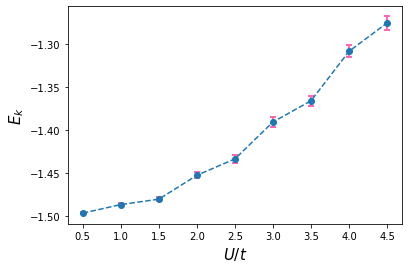

In [13]:
plt.errorbar(U_list,Ek_list[:,0],Ek_list[:,1],fmt='o--',ecolor='hotpink',elinewidth=2,capsize=3,capthick=2)
plt.xlabel(r'$U/t$',{'size':15})
plt.ylabel(r'$E_k$',{'size':15})

Text(0, 0.5, '$<n_{i\\uparrow}n_{i\\downarrow}>$')

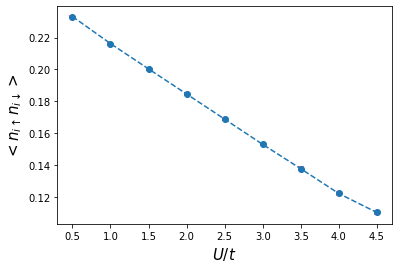

In [14]:
plt.errorbar(U_list,D_list[:,0],D_list[:,1],fmt='o--',ecolor='hotpink',elinewidth=2,capsize=3,capthick=2)
plt.xlabel(r'$U/t$',{'size':15})
plt.ylabel(r'$<n_{i\uparrow}n_{i\downarrow}>$',{'size':15})

Text(0, 0.5, '$S(\\pi,\\pi)$')

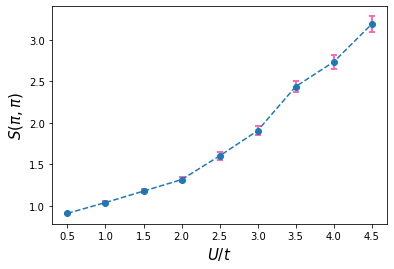

In [15]:
plt.errorbar(U_list,S_list[:,0],S_list[:,1],fmt='o--',ecolor='hotpink',elinewidth=2,capsize=3,capthick=2)
plt.xlabel(r'$U/t$',{'size':15})
plt.ylabel(r'$S(\pi,\pi)$',{'size':15})